In [54]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [55]:
import os
cwd = os.getcwd().replace("\\", "/")
print(cwd)

c:/Users/Timothe/Documents/eth4/cil/github/CIL/models/indep_patch_conv_cls


In [56]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import OneFormerProcessor
from glob import glob
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    CLAHE,
    HueSaturationValue,
    GaussNoise,
    GridDistortion,
    Compose,
    RandomCrop
)

from torch.utils.data import ConcatDataset, DataLoader
from collections import namedtuple


BATCH_SIZE = 2

kaggle = True if cwd == "/kaggle/working" else False
data_path = "/kaggle/input/" if kaggle else cwd + "/../../data/"

#takes path of x and returns x and y as images
def get_label(x_path):
    x_path = x_path.replace("\\", "/")
    if x_path.__contains__("massachusetts"):
        y_path = x_path.replace("tiff/train/", "tiff/train_labels/").replace(".tiff", ".tif")

    if x_path.__contains__("ethz") or x_path.__contains__("suburbs"):
        y_path = x_path.replace("images/", "groundtruth/")

    if x_path.__contains__("roadsegmentation"):
        y_path = x_path.replace("images/", "groundtruth/").replace(".jpg", ".png")

    if x_path.__contains__("deepglobe"):
        y_path = x_path.replace("sat.jpg", "mask.png")

    return Image.open(x_path), Image.open(y_path)


def save(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
    }, path)

def load(model, optim, name):
    path = ("/kaggle/working/" if kaggle else "") + name + ".pth"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])


In [57]:
# Load the model and setup the classifier head for binary classification
name = "shi-labs/oneformer_cityscapes_dinat_large"
#name = "shi-labs/oneformer_ade20k_swin_tiny"

# using feature extractor from OneFormerProcessor
feature_extractor = OneFormerProcessor.from_pretrained(name)
feature_extractor.image_processor.do_resize = False

c:\ProgramData\Anaconda3\lib\site-packages\transformers\models\oneformer\image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [58]:

def get_geometric_transforms_official():
    geometric_transforms = [
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
    ]
    return Compose(geometric_transforms, additional_targets={'mask':'image'})


def get_photometric_transforms():
    return None

return_orig_images = False
class CustomDataset(Dataset):
    def __init__(self, image_files, geometric_transform=None, photometric_transform=None):
        self.image_files = image_files
        self.geometric_transform = geometric_transform
        self.photometric_transform = photometric_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        x_orig, y_orig = get_label(self.image_files[idx])

        x_orig:Image = x_orig.convert("RGB")
        y_orig:Image = y_orig.convert("RGB")

        if x_orig.size[0] == 1024:
            x_orig = x_orig.resize((400, 400))
            y_orig = y_orig.resize((400, 400))

        x_orig_np = np.array(x_orig, dtype=np.uint8)
        y_orig_np = np.array(y_orig, dtype=np.uint8)

        # Apply geometric transforms
        x_augmented, y_augmented = x_orig_np.copy(), y_orig_np.copy()
        if self.geometric_transform:
            augmented = self.geometric_transform(image=x_augmented.copy(), mask=y_augmented.copy())
            x_augmented, y_augmented = augmented['image'], augmented['mask']

        # Apply photometric transforms
        if self.photometric_transform:
            augmented = self.photometric_transform(image=x_augmented.copy())
            x_augmented = augmented['image']

        x = feature_extractor(images=x_augmented.astype(np.float32), task_inputs=["semantic"], return_tensors="pt").pixel_values.squeeze(0).cuda()
        y = torch.tensor((y_augmented.astype(np.float32)/255)[:, :, 0], dtype=torch.float32).unsqueeze(0).cuda()

        if return_orig_images:

            # ensure the orig images have the same size when the datasets are combined
            if x_orig_np.shape[0] == 1500:
                x_orig_np = np.array(Image.fromarray(x_orig_np).resize((400, 400)))
                y_orig_np = np.array(Image.fromarray(y_orig_np).resize((400, 400)))

            # Convert the images to float32
            x_orig_np = x_orig_np.astype(np.float32) / 255
            y_orig_np = y_orig_np.astype(np.float32) / 255
            x_augmented = x_augmented.astype(np.float32) / 255
            y_augmented = y_augmented.astype(np.float32) / 255

            return x, y, self.image_files[idx], x_orig_np, y_orig_np, x_augmented, y_augmented

        else:
            return x, y, self.image_files[idx], torch.zeros(1), torch.zeros(1), torch.zeros(1), torch.zeros(1)



In [59]:
# This is a smaller dataset for weight initialization
googlemaps_dataset = CustomDataset(glob(data_path + "googlemaps-boston-losangeles-suburbs/images/*.png"), get_geometric_transforms_official(), get_photometric_transforms())
googlemaps_loader = DataLoader(googlemaps_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:
# googlemaps2_dataset = CustomDataset(glob(data_path + "roadsegmentation-boston-losangeles/images/*.jpg")[:-1], get_geometric_transforms_official(), get_photometric_transforms())
# googlemaps2_loader = DataLoader(googlemaps2_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [61]:
main_dataset_len = len(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))

# Split the dataset
val_size = int(main_dataset_len * 0.1)
train_size = main_dataset_len - val_size
torch.manual_seed(0)
indices = torch.randperm(main_dataset_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Apply transformations only on training set
train_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], None, None)
train_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[train_indices], get_geometric_transforms_official(), get_photometric_transforms())
val_dataset = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], None, None)
val_dataset_augmented = CustomDataset(np.array(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"))[val_indices], get_geometric_transforms_official(), get_photometric_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [62]:
# independent 16x16 patch classification using CNNs
class IndepPatchClsModel(nn.Module):
    def __init__(self, patch_size=16):
        super().__init__()
        assert patch_size < 400
        self.indep_patch_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=patch_size, stride=patch_size, padding='valid'),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding='same'),
        )
        self.converter = nn.Sequential(
            nn.Upsample((400, 400), mode='nearest'),
            # nn.Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
        )

    def forward(self, x):
        return namedtuple('output', 'logits')(self.converter(self.indep_patch_layer(x)))

model = IndepPatchClsModel(patch_size=16).cuda()

In [63]:
def visualize_sample(loader, model=None, rows=4):
    global return_orig_images
    return_orig_images = True

    if model:
        model.eval()

    with torch.no_grad():
        fig, ax = plt.subplots(rows, 5, figsize=(40, 40))
        for i, (x, y, name, x_orig, y_orig, x_augmented, y_augmented) in enumerate(loader):
            x = x[0]
            y = y[0]
            name = name[0]

            x_orig = x_orig[0]
            y_orig = y_orig[0]
            x_augmented = x_augmented[0]
            y_augmented = y_augmented[0]

            if model:
                pred = model(x.unsqueeze(0)).logits.squeeze(0)
                pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()

            y = y.permute(1, 2, 0).cpu().numpy()
            x = x.permute(1, 2, 0).cpu().numpy()

            ax[i][0].imshow(x_orig)
            ax[i][1].imshow(y_orig)
            ax[i][2].imshow(x_augmented)
            ax[i][3].imshow(y_augmented)

            if model:
                ax[i][4].imshow(pred, cmap='gray')


            if i == rows - 1:
                break

    if model:
        model.train()

    return_orig_images = False


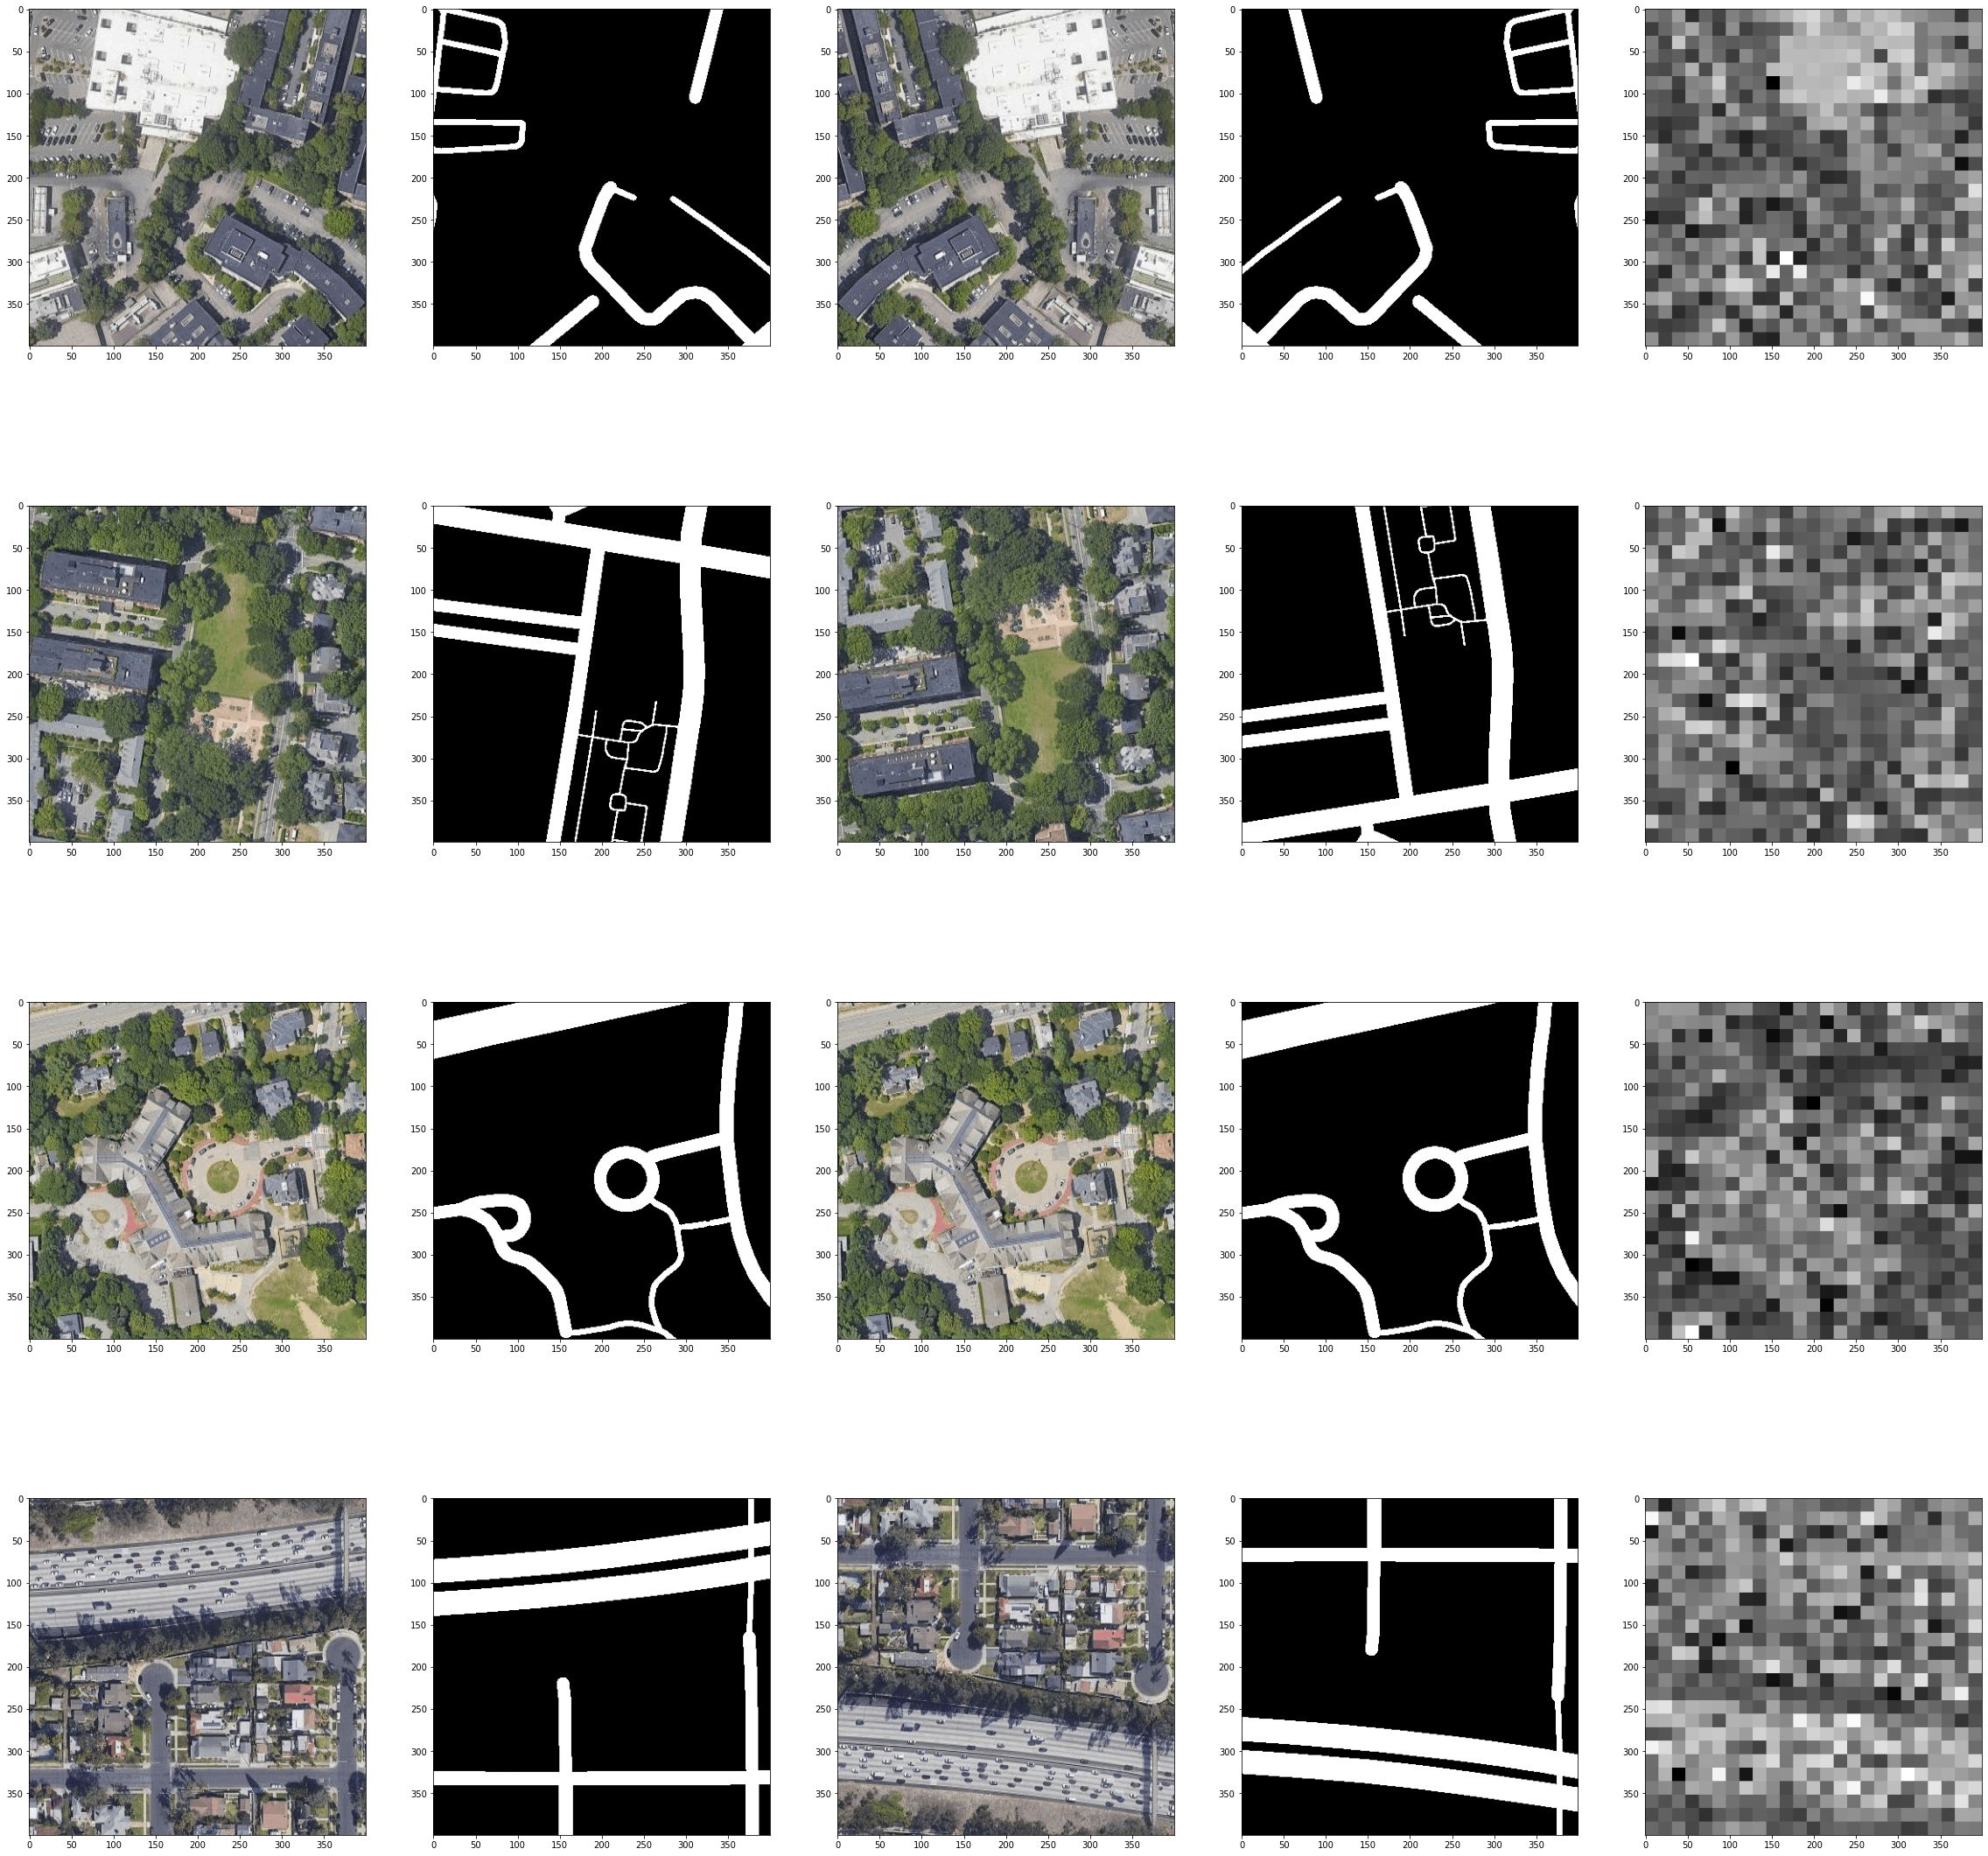

In [64]:
# shapes:
# x shape: torch.Size([2, 3, 400, 400]) y shape: torch.Size([2, 1, 400, 400]) x_aug shape: torch.Size([2, 400, 400, 3]) y_aug shape: torch.Size([2, 400, 400, 3])
visualize_sample(googlemaps_loader, model=model)

In [65]:
# Set up training
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [66]:
use_wandb = False

def train(model, dataset, optimizer):
    torch.backends.cudnn.benchmark = True
    model.train()
    total_loss = 0
    steps = 0
    for x, y, _a, _b, _c, _d, _e in tqdm(dataset):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_pred = model(x).logits
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1
        if steps % 100 == 0:
            print("Training Loss:", total_loss / steps)
            if use_wandb: wandb.log({"Train Loss": total_loss / steps})

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})

In [67]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([], dtype=np.float32)
    y_gt = np.array([], dtype=np.float32)
    with torch.no_grad():
        for x, y, _a, _b, _c, _d, _e in dataset:
            x, y = x.cuda(), y.cuda()
            # print(x.shape , y.shape)
            y_pred = model(x).logits
            y_pred = torch.sigmoid(y_pred)

            # apply pooling to reduce the prediction from 400x400 to 25x25
            y_pred = F.avg_pool2d(y_pred, 16, stride=16)
            # apply pooling to reduce the label from 400x400 to 25x25
            y = F.avg_pool2d(y, 16, stride=16)

            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))


    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt)
    for tresh in np.arange(0.15,0.40,0.05):
        score = f1_score(y_gt>0.25, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))


In [68]:
for epoch in range(1):
    train(model, train_loader_augmented, optimizer)
    validate(model, val_loader)

  3%|▎         | 2/65 [00:00<00:04, 13.07it/s]

100%|██████████| 65/65 [00:04<00:00, 13.48it/s]


Training Loss: 0.6782412785750169
Validation F1 Score for tresh 0.15 : 0.41453419542846726
Validation F1 Score for tresh 0.2 : 0.42361111111111105
Validation F1 Score for tresh 0.25 : 0.42450853208262646
Validation F1 Score for tresh 0.30000000000000004 : 0.39837398373983735
Validation F1 Score for tresh 0.3500000000000001 : 0.3483642793987622


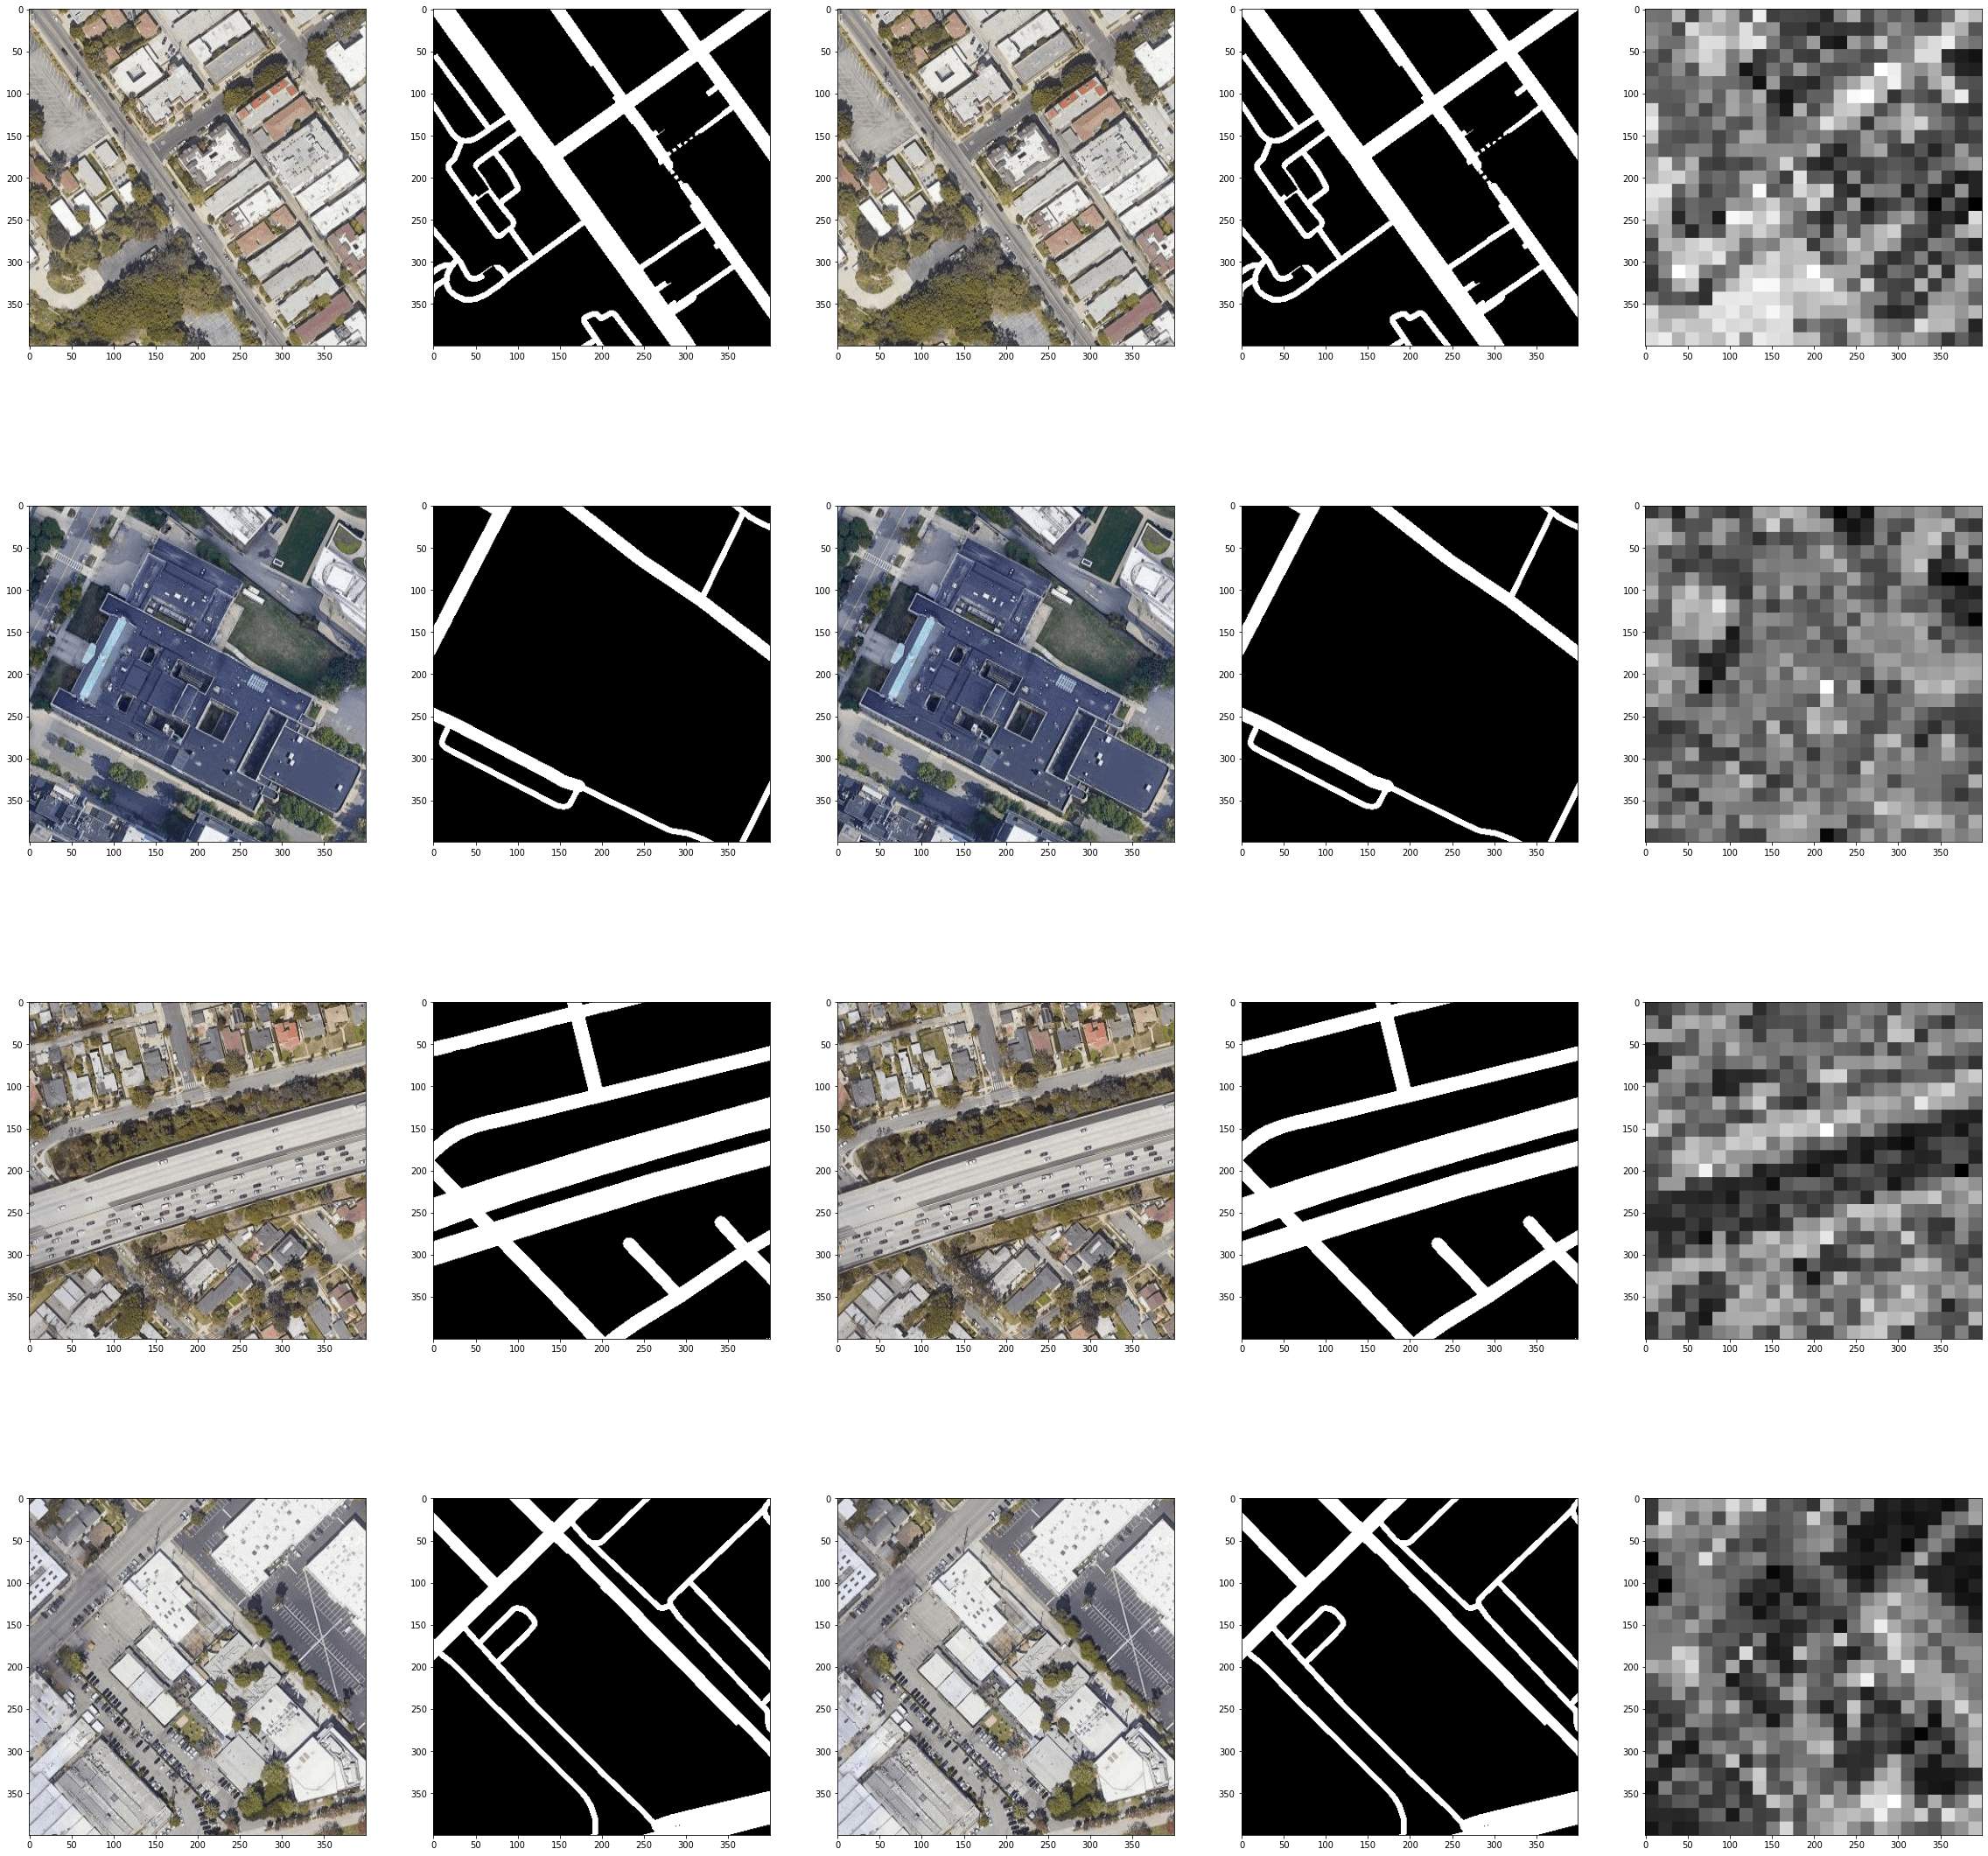

In [69]:
visualize_sample(val_loader, model=model)

In [70]:
if use_wandb: wandb.finish()

In [71]:
# predicted image files
with torch.no_grad():
    test_path = data_path + "ethz-cil-road-segmentation-2023/" + "test/images/"
    model.eval()
    files = os.listdir(test_path)
    for file in tqdm(files):
        # print(test_path)
        # print(file)
        x_orig:Image = Image.open(test_path + file).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)
        x = feature_extractor(images=x_orig, task_inputs=["semantic"], return_tensors="pt").pixel_values.squeeze(0).cuda()
        pred = model(x.unsqueeze(0)).logits
        #pred = torch.repeat_interleave(torch.repeat_interleave(pred, 2, dim=2), 2, dim=3)
        pred = pred.squeeze(0)
        pred = torch.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
        # print(pred.shape) # (400, 400, 1)
        pred = pred.squeeze(-1)
        # print(pred.shape) # (400, 400)
        pred = Image.fromarray((pred*255).astype(np.uint8))

        output_dir = "./test_preds/"
        #make the folder
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        pred.save(output_dir + file)


  1%|▏         | 2/144 [00:00<00:11, 12.90it/s]

100%|██████████| 144/144 [00:05<00:00, 25.34it/s]


In [72]:
# # zip the folder
# import shutil
# shutil.make_archive("./test_preds", 'zip', ".")